In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.1613

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - loss: 0.1291
Average validation loss: 0.6930210590362549
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - loss: 0.1291 - val_loss: 0.6930
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 503ms/step - loss: 0.0915 - val_loss: 0.6930
Average validation loss: 0.529822051525116
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 514ms/step - loss: 0.0915 - val_loss: 0.6114
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 495ms/step - loss: 0.0688 - val_loss: 0.6114
Average validation loss: 0.4621754288673401
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 507ms/step - loss: 0.0688 - val_loss: 0.5617
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 799ms/step - loss: 4.2931e-04
Average validation loss: 0.3010292649269104
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 808ms/step - loss: 4.2931e-04 - val_loss: 0.3010
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 799ms/step - loss: 4.0457e-04 - val_loss: 0.3010
Average validation loss: 0.2980141043663025
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 811ms/step - loss: 4.0457e-04 - val_loss: 0.2995
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 840ms/step - loss: 4.0699e-04 - val_loss: 0.2995
Average validation loss: 0.28264007717370987
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 853ms/step - loss: 4.0699e-04 - val_loss: 0.2939
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weigh

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 817ms/step - loss: 2.6978e-04
Average validation loss: 0.10423970719178517
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 829ms/step - loss: 2.6978e-04 - val_loss: 0.1042
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 793ms/step - loss: 1.9927e-04 - val_loss: 0.1042
Average validation loss: 0.11806259800990422
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 805ms/step - loss: 1.9927e-04 - val_loss: 0.1112
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 785ms/step - loss: 1.7993e-04 - val_loss: 0.1112
Average validation loss: 0.04308750107884407
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 798ms/step - loss: 1.7993e-04 - val_loss: 0.0885
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_15.pth'.
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 796ms/step - loss: 1.5816e-04 - val_loss

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 833ms/step - loss: 4.8721e-05
Average validation loss: 0.03642746713012457
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 842ms/step - loss: 4.8721e-05 - val_loss: 0.0364
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 847ms/step - loss: 3.8147e-05 - val_loss: 0.0364
Average validation loss: 0.016202617553062737
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 858ms/step - loss: 3.8147e-05 - val_loss: 0.0263
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 814ms/step - loss: 3.3752e-05 - val_loss: 0.0263
Average validation loss: 0.032864205772057176
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 826ms/step - loss: 3.3752e-05 - val_loss: 0.0285
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 827ms/step - loss: 3.2636e-05 - val_lo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 840ms/step - loss: 8.1774e-05
Average validation loss: 0.1233963891863823
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 850ms/step - loss: 8.1774e-05 - val_loss: 0.1234
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 819ms/step - loss: 5.7281e-05 - val_loss: 0.1234
Average validation loss: 0.0165193947032094
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 830ms/step - loss: 5.7281e-05 - val_loss: 0.0700
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 797ms/step - loss: 4.6183e-05 - val_loss: 0.0700
Average validation loss: 0.024628563225269316
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 807ms/step - loss: 4.6183e-05 - val_loss: 0.0548
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 837ms/step - loss: 3.9101e-05 - val_loss:

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 796ms/step - loss: 6.5304e-05
Average validation loss: 0.012727909178162614
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 806ms/step - loss: 6.5304e-05 - val_loss: 0.0127
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 805ms/step - loss: 5.1316e-05 - val_loss: 0.0127
Average validation loss: 0.008342846568363408
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 815ms/step - loss: 5.1316e-05 - val_loss: 0.0105
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 794ms/step - loss: 4.6161e-05 - val_loss: 0.0105
Average validation loss: 0.013106404415642222
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 804ms/step - loss: 4.6161e-05 - val_loss: 0.0114
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 77s 794ms/step - loss: 3.9407e-05 - val_l

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 794ms/step - loss: 4.8709e-05
Average validation loss: 0.01813112187664956
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 804ms/step - loss: 4.8709e-05 - val_loss: 0.0181
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 757ms/step - loss: 3.5491e-05 - val_loss: 0.0181
Average validation loss: 0.01418288991553709
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 768ms/step - loss: 3.5491e-05 - val_loss: 0.0162
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 796ms/step - loss: 2.8100e-05 - val_loss: 0.0162
Average validation loss: 0.011797575792297722
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 805ms/step - loss: 2.8100e-05 - val_loss: 0.0147
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_seg

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 793ms/step - loss: 2.7868e-05
Average validation loss: 0.010795206394201765
48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 804ms/step - loss: 2.7868e-05 - val_loss: 0.0108
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 77s 805ms/step - loss: 1.8721e-05 - val_loss: 0.0108
Average validation loss: 0.009109395750177404
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 817ms/step - loss: 1.8721e-05 - val_loss: 0.0100
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 117s 817ms/step - loss: 1.5546e-05 - val_loss: 0.0100
Average validation loss: 0.007250336794337879
48/48 ━━━━━━━━━━━━━━━━━━━━ 118s 828ms/step - loss: 1.5546e-05 - val_loss: 0.0091
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 804ms/step - loss: 1.4011e-05
Average validation loss: 0.007702495836253677
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 816ms/step - loss: 1.4011e-05 - val_loss: 0.0077
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 807ms/step - loss: 9.6441e-06 - val_loss: 0.0077
Average validation loss: 0.006792601547203958
56/56 ━━━━━━━━━━━━━━━━━━━━ 92s 819ms/step - loss: 9.6441e-06 - val_loss: 0.0072
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 139s 836ms/step - loss: 7.7772e-06 - val_loss: 0.0072
Average validation loss: 0.0076386961653562525
56/56 ━━━━━━━━━━━━━━━━━━━━ 139s 848ms/step - loss: 7.7772e-06 - val_loss: 0.0074
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 186s 831ms/step - loss: 6.6188e-06 - v

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 815ms/step - loss: 7.5309e-06
Average validation loss: 0.009260519495001063
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 827ms/step - loss: 7.5309e-06 - val_loss: 0.0093
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 794ms/step - loss: 5.9457e-06 - val_loss: 0.0093
Average validation loss: 0.0073228602050221525
64/64 ━━━━━━━━━━━━━━━━━━━━ 105s 805ms/step - loss: 5.9457e-06 - val_loss: 0.0083
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 155s 793ms/step - loss: 4.8102e-06 - val_loss: 0.0083
Average validation loss: 0.006953357878956012
64/64 ━━━━━━━━━━━━━━━━━━━━ 156s 804ms/step - loss: 4.8102e-06 - val_loss: 0.0078
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 796ms/step - loss: 5.0938e-06
Average validation loss: 0.015589910772784302
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 807ms/step - loss: 5.0938e-06 - val_loss: 0.0156
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 794ms/step - loss: 4.6821e-06 - val_loss: 0.0156
Average validation loss: 0.010058846198565638
72/72 ━━━━━━━━━━━━━━━━━━━━ 116s 805ms/step - loss: 4.6821e-06 - val_loss: 0.0128
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 173s 794ms/step - loss: 4.4278e-06 - val_loss: 0.0128
Average validation loss: 0.02804596505787534
72/72 ━━━━━━━━━━━━━━━━━━━━ 174s 805ms/step - loss: 4.4278e-06 - val_loss: 0.0179
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 231s 797ms/step - loss: 4.1423e-06 - v

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 793ms/step - loss: 5.3141e-06
Average validation loss: 0.008914111045305618
80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 805ms/step - loss: 5.3141e-06 - val_loss: 0.0089
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 129s 809ms/step - loss: 5.7108e-06 - val_loss: 0.0089
Average validation loss: 0.00653361329168547
80/80 ━━━━━━━━━━━━━━━━━━━━ 130s 820ms/step - loss: 5.7108e-06 - val_loss: 0.0077
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 201s 887ms/step - loss: 4.8192e-06 - val_loss: 0.0077
Average validation loss: 0.006954754263279028
80/80 ━━━━━━━━━━━━━━━━━━━━ 202s 898ms/step - loss: 4.8192e-06 - val_loss: 0.0075
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 268s 831ms/step - loss: 4.4639e-06 -

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 856ms/step - loss: 8.4279e-06
Average validation loss: 0.01031275128480047
96/96 ━━━━━━━━━━━━━━━━━━━━ 83s 867ms/step - loss: 8.4279e-06 - val_loss: 0.0103
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 160s 799ms/step - loss: 6.0868e-06 - val_loss: 0.0103
Average validation loss: 0.012921327608637512
96/96 ━━━━━━━━━━━━━━━━━━━━ 161s 810ms/step - loss: 6.0868e-06 - val_loss: 0.0116
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 238s 804ms/step - loss: 4.9314e-06 - val_loss: 0.0116
Average validation loss: 0.013117186773646003
96/96 ━━━━━━━━━━━━━━━━━━━━ 239s 815ms/step - loss: 4.9314e-06 - val_loss: 0.0121
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 317s 811ms/step - loss: 4.3281e-06 - val_loss: 0.0121
Average validation loss: 0.010007790445039669
96/96 ━━━━━━━━━━━━━━━━━━━━ 318s 821ms/step - loss: 4.3281e-06 - val_loss: 0.0116
Saved 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 794ms/step - loss: 1.9183e-05
Average validation loss: 0.0071881649647063265
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 805ms/step - loss: 1.9183e-05 - val_loss: 0.0072
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 195s 820ms/step - loss: 1.3720e-05 - val_loss: 0.0072
Average validation loss: 0.008952514617703855
120/120 ━━━━━━━━━━━━━━━━━━━━ 196s 831ms/step - loss: 1.3720e-05 - val_loss: 0.0081
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 292s 796ms/step - loss: 1.0795e-05 - val_loss: 0.0081
Average validation loss: 0.006278123828815296
120/120 ━━━━━━━━━━━━━━━━━━━━ 293s 808ms/step - loss: 1.0795e-05 - val_loss: 0.0075
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_150.pth'.
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 390s 803ms/step - lo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 117s 809ms/step - loss: 1.6812e-05
Average validation loss: 0.00912062175403763
144/144 ━━━━━━━━━━━━━━━━━━━━ 118s 820ms/step - loss: 1.6812e-05 - val_loss: 0.0091
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 233s 798ms/step - loss: 1.3391e-05 - val_loss: 0.0091
Average validation loss: 0.006909496454884195
144/144 ━━━━━━━━━━━━━━━━━━━━ 235s 809ms/step - loss: 1.3391e-05 - val_loss: 0.0080
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 349s 796ms/step - loss: 1.0703e-05 - val_loss: 0.0080
Average validation loss: 0.006231068914833789
144/144 ━━━━━━━━━━━━━━━━━━━━ 351s 807ms/step - loss: 1.0703e-05 - val_loss: 0.0074
Saved model weights to 'c:\天_11157065\git\RipplesDetection\w

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 127s 794ms/step - loss: 5.9239e-06
Average validation loss: 0.00872332656290382
160/160 ━━━━━━━━━━━━━━━━━━━━ 129s 806ms/step - loss: 5.9239e-06 - val_loss: 0.0087
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 255s 788ms/step - loss: 4.8928e-06 - val_loss: 0.0087
Average validation loss: 0.007944874386885204
160/160 ━━━━━━━━━━━━━━━━━━━━ 257s 799ms/step - loss: 4.8928e-06 - val_loss: 0.0083
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 387s 813ms/step - loss: 3.9617e-06 - val_loss: 0.0083
Average validation loss: 0.00702476768346969
160/160 ━━━━━━━━━━━━━━━━━━━━ 388s 824ms/step - loss: 3.9617e-06 - val_loss: 0.0079
Saved model weights to 'c:\天_11157065\git\RipplesDetection\we

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 157s 788ms/step - loss: 7.8860e-06
Average validation loss: 0.020515640505379906
200/200 ━━━━━━━━━━━━━━━━━━━━ 160s 799ms/step - loss: 7.8860e-06 - val_loss: 0.0205
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 319s 795ms/step - loss: 6.3169e-06 - val_loss: 0.0205
Average validation loss: 0.0062227442019502635
200/200 ━━━━━━━━━━━━━━━━━━━━ 321s 806ms/step - loss: 6.3169e-06 - val_loss: 0.0134
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 480s 793ms/step - loss: 5.0600e-06 - val_loss: 0.0134
Average validation loss: 0.006803976741248334
200/200 ━━━━━━━━━━━━━━━━━━━━ 482s 804ms/step - loss: 5.0600e-06 - val_loss: 0.0112
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 644s 812ms/step - 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 191s 795ms/step - loss: 4.6263e-06
Average validation loss: 0.009004470204066214
240/240 ━━━━━━━━━━━━━━━━━━━━ 194s 806ms/step - loss: 4.6263e-06 - val_loss: 0.0090
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 388s 809ms/step - loss: 3.7257e-06 - val_loss: 0.0090
Average validation loss: 0.011270246312293845
240/240 ━━━━━━━━━━━━━━━━━━━━ 390s 819ms/step - loss: 3.7257e-06 - val_loss: 0.0101
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 588s 825ms/step - loss: 3.2278e-06 - val_loss: 0.0101
Average validation loss: 0.004943015862227185
240/240 ━━━━━━━━━━━━━━━━━━━━ 591s 835ms/step - loss: 3.2278e-06 - val_loss: 0.0084
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_0\segformer_data_size_300.pth'.
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 780s 789ms/step - l

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.2199473287910223, 0.19327277082949876, 0.07062633987826607, 0.035443173760431816, 0.02289679068000987, 0.018877532602249024, 0.014163790758117103, 0.009221280726099696, 0.008165323322505823, 0.0071401897675241344, 0.0066237095882792744, 0.004905508882191498, 0.008188796907367457, 0.006863788766087964, 0.00790658119410466, 0.009069382674415635, 0.006438710157585343, 0.00597556624963965]
std_val_losses =  [0.15939773621810654, 0.21471827384099268, 0.07067287408145215, 0.032018383466403816, 0.02072466921743738, 0.025199077693477054, 0.010423004354811796, 0.004811047017570511, 0.005487552195499951, 0.0038271342967147043, 0.0046383816550502185, 0.0022698353323113776, 0.010481260214642987, 0.003112688916071577, 0.0036442319341360176, 0.008343166424510636, 0.0033177667548925658, 0.003040828979223539]


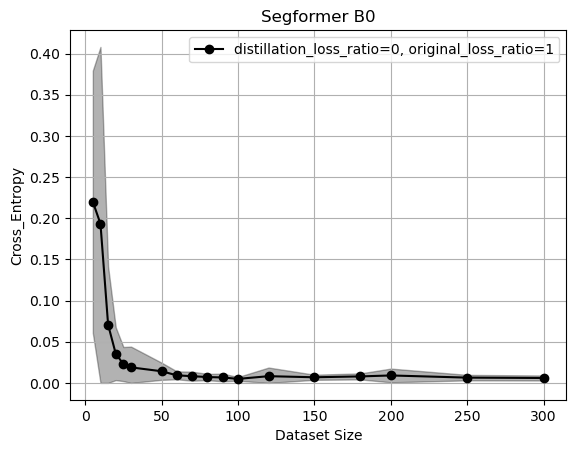

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()